<center><h1>Tri-Axial Gyroscope Classifier</h1>
    <h2>by Rebecca Hinrichs</h2>
    <h3>SUMMER 2023</h3></center>

---

<b>Purpose:</b> The purpose of this assignment is to test concepts on building & training LSTM models.

<b>Data:</b> We were provided with a folder `UCI HAR Dataset` from the publicly-available data `Human Activity Recognition Using Smartphones`, available <a href="https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones">here</a>. The data consists of 6 activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING. Each activity is recorded for a series of 128 time points. During each time point, 9 features are measured elated to Triaxial acceleration from the accelerometer and Triaxial Angular velocity from the gyroscope.

* 9 features at each time point are:

  - x, y, and z acceleration signals from smartphone accelerometer.
  - x, y, and z body acceleration signals.
  - x, y, and z angular velocities measured by the gyroscope.

We collected the files according to their provided pre-divided train and test data sets as follows:

- `'train/Inertial Signals/total_acc_x_train.txt'`: The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_x_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 

- `'train/Inertial Signals/body_acc_x_train.txt'`: The body acceleration signal obtained by subtracting the gravity from the total acceleration. 

- `'train/Inertial Signals/body_gyro_x_train.txt'`: The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 


<b>Approach:</b> We will build & train four (4) models matching the architecture we were provided in Dr. Soibam's `TextClassification_LSTM.ipynb` Jupyter Notebook. They will consist of the following:

- a single-layer LSTM Model
- a dual-layer LSTM Model
- a combination CNN-LSTM Model, and
- a bidirectional LSTM Model

Using early stopping criterion, we will save and report the loss & accuracy of the best model. 

--- 

--- 

<center><h2>Data Preparation</h2></center>

--- 

#### Data Import

In [1]:
# Collect the timepoint data from the provided directories
from os import listdir
# Load file directories
feature_dir = 'Inertial Signals/'
train_dir, test_dir = 'UCI HAR Dataset/train/', 'UCI HAR Dataset/test/'
train_files, test_files = listdir(train_dir+feature_dir), listdir(test_dir+feature_dir)

# Load class label data
import numpy as np
y_train = np.loadtxt(f'{train_dir}y_train.txt')
y_test = np.loadtxt(f'{test_dir}y_test.txt')
sample_train_file = np.loadtxt(train_dir+feature_dir+train_files[0])
sample_test_file = np.loadtxt(test_dir+feature_dir+test_files[0])

# Report data shapes
print('\nTotal Humans Sampled :: ' + str(len(y_train)+len(y_test)))
print('\nNumber of training samples :: ' + str(len(y_train)))
print('Number of testing samples :: ' + str(len(y_test)))
print('\nNumber of training timepoints :: ', sample_train_file.shape[1])
print('Number of testing timepoints :: ', sample_test_file.shape[1])
print('\nNumber of training features :: ' + str(len(train_files)))
print('Number of testing features :: ' + str(len(test_files)) +'\n')


Total Humans Sampled :: 10299

Number of training samples :: 7352
Number of testing samples :: 2947

Number of training timepoints ::  128
Number of testing timepoints ::  128

Number of training features :: 9
Number of testing features :: 9



#### Single Series Data Analysis (EDA)


Sample training timeseries sequence for random human ::
 [0.9620252 0.9612799 0.9648862 0.9699091 0.9696765 0.9661158 0.9651509
 0.9683861 0.973251  0.9735812 0.9678004 0.9635482 0.965117  0.9671633
 0.9664314 0.966381  0.9661513 0.9646163 0.9651567 0.9645439 0.9624758
 0.9636626 0.9659807 0.9672943 0.9667655 0.9661956 0.9670691 0.9663719
 0.9657961 0.9661847 0.9667521 0.9680041 0.9680412 0.9679124 0.9669225
 0.9643597 0.96329   0.96326   0.9642362 0.9656764 0.9651645 0.9632264
 0.9619539 0.9622977 0.9620262 0.9615482 0.9632559 0.965525  0.9674782
 0.9685209 0.9680652 0.9680557 0.9687026 0.9682938 0.9677713 0.9690833
 0.9692297 0.9656459 0.9631374 0.9655701 0.9687717 0.9682502 0.9675449
 0.9684744 0.9681031 0.9689746 0.9709123 0.9703969 0.9681891 0.9657862
 0.966669  0.9692219 0.969679  0.9705547 0.9712011 0.9716404 0.972622
 0.9723485 0.973181  0.9749161 0.9752668 0.9749767 0.9750321 0.9760373
 0.9766261 0.9762369 0.9754261 0.9747081 0.9748085 0.9742275 0.9736086
 0.9754942 0.9778637

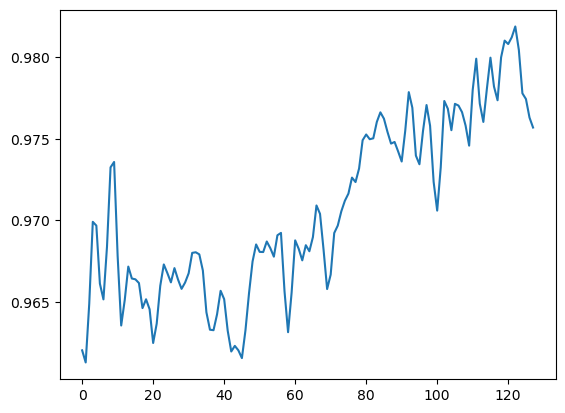

In [2]:
# Display a sample of a time series set from one human in the training data
pick_me = np.random.randint(0,len(train_files)) # pick a random feature set
sample_feature = np.loadtxt(train_dir+feature_dir+train_files[pick_me])
pick_me = np.random.randint(0,len(y_train)) # pick a random human's time data
sample_series = np.array(sample_feature[pick_me])

# Display a sample of a time series set as a plot
from matplotlib import pyplot as plt
plt.plot(range(len(sample_series)), sample_series)

# Describe the data
print('\nSample training timeseries sequence for random human ::\n', sample_series)
print('\nSample feature dimensions ::\t', sample_feature.shape, sep='')
print('Sample human feature data dimensions ::\t', sample_series.shape, sep='')
print('Sample sequence value range ::\t', \
      sample_series.min(), 'to', sample_series.max(), '\n')

<center><h2><u>Data→Tensor Transformation</u></h2></center>

In [3]:
# Store the Training Data into 3D tensors
SEQ_DIM = (sample_train_file.shape[1], len(train_files)) # shape of each sequence
print('\nTransferring time series data from training directory...')
x_train = np.zeros(shape=(sample_train_file.shape[0], SEQ_DIM[0], SEQ_DIM[1]))
y_train -= np.min(y_train) # ensure labels begin at zero
for i in range(len(train_files)):
    print(f'processing {train_files[i]}')
    x_train[:,:,i] = np.loadtxt(train_dir+feature_dir+train_files[i])
    if i == (len(train_files)-1):
        print('done! ' +str(len(train_files))+ ' sequence sets were vectorized\n')

# Store the Testing Data into 3D tensors
print('Transferring time series data from testing directory...')
x_test = np.zeros(shape=(sample_test_file.shape[0], SEQ_DIM[0], SEQ_DIM[1]))
y_test -= np.min(y_test) # ensure labels begin at zero
for i in range(len(test_files)):
    print(f'processing {test_files[i]}')
    x_test[:,:,i] = np.loadtxt(test_dir+feature_dir+test_files[i])
    if i == (len(test_files)-1):
        print('done! ' +str(len(test_files))+ ' sequence sets were vectorized\n')

# Store tensors in 'h5' file for later use
import h5py
filename = 'Final_Hinrichs_seqs-labels.h5'
hf = h5py.File(filename, 'w')
hf.create_dataset('x_train', data=x_train)
hf.create_dataset('y_train', data=y_train)
hf.create_dataset('x_test', data=x_test)
hf.create_dataset('y_test', data=y_test)
hf.close()
print('Success! Time series data of ' +str(len(x_train)+len(x_test)) \
                         +' humans stored at ' +str(filename)+'\n')


Transferring time series data from training directory...
processing body_acc_x_train.txt
processing body_acc_y_train.txt
processing body_acc_z_train.txt
processing body_gyro_x_train.txt
processing body_gyro_y_train.txt
processing body_gyro_z_train.txt
processing total_acc_x_train.txt
processing total_acc_y_train.txt
processing total_acc_z_train.txt
done! 9 sequence sets were vectorized

Transferring time series data from testing directory...
processing body_acc_x_test.txt
processing body_acc_y_test.txt
processing body_acc_z_test.txt
processing body_gyro_x_test.txt
processing body_gyro_y_test.txt
processing body_gyro_z_test.txt
processing total_acc_x_test.txt
processing total_acc_y_test.txt
processing total_acc_z_test.txt
done! 9 sequence sets were vectorized

Success! Time series data of 10299 humans stored at Final_Hinrichs_seqs-labels.h5



In [4]:
# Describe the data shapes & labels
print('\nTraining Shape  ::', x_train.ndim, 'dimensions', x_train.shape)
print('Training Labels ::', y_train.ndim, 'dimensions', y_train.shape)
print('\nTesting Shape   ::', x_test.ndim, 'dimensions', x_test.shape)
print('Testing Labels  ::', y_test.ndim, 'dimensions', y_test.shape)
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

# Peek at the data & labels
print('\nImported Data')
print('Classes are::\t', np.unique(y_train, return_counts=True)[0])
print(' # per class:\t', np.unique(y_train, return_counts=True)[1])

# Describe the classifiers
label_descriptors = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 
                     'SITTING', 'STANDING', 'LAYING']
print(f'\n <Label>\t<Descriptor>')
for _ in range(len(np.unique(y_train))):
    print(f'{np.unique(y_train)[_]:>5}\t\t{label_descriptors[_]:<10}')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

# Display a sample image now as 3D Tensor
pick_me = np.random.randint(0,len(train_files)) # pick a random timepoint sequence
print('\nSample training sequence (vectorized) ::')
display(x_train[pick_me,0,:])


Training Shape  :: 3 dimensions (7352, 128, 9)
Training Labels :: 1 dimensions (7352,)

Testing Shape   :: 3 dimensions (2947, 128, 9)
Testing Labels  :: 1 dimensions (2947,)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Imported Data
Classes are::	 [0. 1. 2. 3. 4. 5.]
 # per class:	 [1226 1073  986 1286 1374 1407]

 <Label>	<Descriptor>
  0.0		WALKING   
  1.0		WALKING_UPSTAIRS
  2.0		WALKING_DOWNSTAIRS
  3.0		SITTING   
  4.0		STANDING  
  5.0		LAYING    
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Sample training sequence (vectorized) ::


array([ 3.530000e-03,  4.455942e-03, -5.914581e-03,  2.618877e-02,
       -2.383410e-04,  2.158897e-03,  1.023127e+00, -1.200157e-01,
        9.111667e-02])

<center><h2><u>Data Pre-Processing</u></h2></center>

#### Normalize the inputs (x-data)

In [5]:
# Scale X-array values respectively
print(f'\nPre-scaled values in \'x\'  :: {x_train.min()} to {x_train.max()}')
mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_train -= mean
x_test -= mean
x_train /= std
x_test /= std

# Check previous sample image to ensure it worked
print(f'Post-scaled values in \'x\' :: {x_train.min()} to {x_train.max()}')
print('\nSample training image (scaled) ::')
display(x_train[pick_me,0,:])


Pre-scaled values in 'x'  :: -5.97433 to 5.746062
Post-scaled values in 'x' :: -15.279811636926576 to 14.954097346173072

Sample training image (scaled) ::


array([ 0.03478841,  0.03894064, -0.0968578 ,  0.06428018, -0.02482155,
       -0.00387835,  0.52913885, -0.37763099,  0.00190239])

#### Categorize the outputs (y-data)

In [6]:
# Transform float Y-array values to integers
from keras.utils import np_utils
NB_CLASSES = int(len(np.unique(y_train))) # number of classes
print('\nBEFORE CATEGORIZATION:')
print('Training Label Values ::', np.unique(y_train))
print('Testing Label Values ::', np.unique(y_test))
print('\nTraining Label Shape ::', y_train.shape)
print('Testing Label Shape ::', y_test.shape)
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)
print('\nAFTER CATEGORIZATION:')
print('Training Label Values ::', np.unique(y_train))
print('Testing Label Values ::', np.unique(y_test))
print('\nTraining Label Shape ::', y_train.shape)
print('Testing Label Shape ::', y_test.shape)


BEFORE CATEGORIZATION:
Training Label Values :: [0. 1. 2. 3. 4. 5.]
Testing Label Values :: [0. 1. 2. 3. 4. 5.]

Training Label Shape :: (7352,)
Testing Label Shape :: (2947,)

AFTER CATEGORIZATION:
Training Label Values :: [0. 1.]
Testing Label Values :: [0. 1.]

Training Label Shape :: (7352, 6)
Testing Label Shape :: (2947, 6)


#### Store pre-processed data in `h5` file

In [7]:
# Store tensor data in 'h5' file for later use
import h5py
hf = h5py.File('generated_files/Final_Hinrichs_source-data.h5', 'w')
hf.create_dataset('x_train', data=x_train)
hf.create_dataset('x_test', data=x_test)
hf.create_dataset('y_train', data=y_train)
hf.create_dataset('y_test', data=y_test)
hf.close()

--- 

<center><h2>Model Construction</h2></center>

--- 

#### Import Source Data & Libraries

In [1]:
# Import pre-processed tensor data from 'h5' file
import numpy as np
import h5py
hf = h5py.File('generated_files/Final_Hinrichs_source-data.h5', 'r')
x_train = np.array(hf['x_train'])
x_test = np.array(hf['x_test'])
y_train = np.array(hf['y_train'])
y_test = np.array(hf['y_test'])
hf.close()

# Describe the data shapes (4D Tensors)
print('\nTraining Shape ::', x_train.shape)
print('Training Labels ::', y_train.shape)
print('\nTesting Shape ::', x_test.shape)
print('Testing Labels ::', y_test.shape)

# Import ML libraries & dependencies
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint
print('\n- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
import time  # to track execution time
from tensorflow.keras import Input


Training Shape :: (7352, 128, 9)
Training Labels :: (7352, 6)

Testing Shape :: (2947, 128, 9)
Testing Labels :: (2947, 6)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


#### Define Global Variables

In [2]:
# Define fixed parameters for model fitting
NB_CLASSES = int(len(y_train[1])) # number of classes:: 6
N_SAMPLES = x_train.shape[0] # number of training samples:: 7352
SEQ_DIM = (x_train.shape[1], x_train.shape[2]) # shape of each sequence:: 128x9
NB_EPOCH = 3*SEQ_DIM[1] # number of iterations:: 27 (we may add more later)
BATCH_SIZE = 32 # mini batch size
VERBOSE = 0 # mute results during training
VALIDATION_SPLIT = 0.2 # 80% training and 20% validation
LOSS = 'categorical_crossentropy' # for categorical classification
METRICS = ['accuracy'] # parameter tuner; converts to CategoricalAccuracy
filepaths = list()  # to store list of h5 files containing fitted models

# Define fixed hyperparameter tuning variables for model compiling
NUM_KERNELS = [32, 64, 100, 128, 1] # number of kernels / filters / units / layers
K_SIZE = [int(n) for n in range(10)] # size of window for kernel dims
STRIDES = 1  # size of window shift for each pooling step
DROPOUT = [0.2, 0.3, 0.5] # 20% or 30% or 50% dropout rates
ACTIVATOR = ['relu', 'softmax']  # activation functions

#### Define Objective Function

In [3]:
# Objective function fits a compiled model using a dataset, optimizing for minimal loss
from hyperopt import STATUS_OK
def model_tuner(model, x_data, y_data, patience=2):
    start_clock = time.process_time_ns()
    
    # Functions to stop overfitting
    early_stopping_monitor = EarlyStopping(monitor='val_loss', 
                                           patience=patience, mode='min')
    filepath = 'generated_files/Final_Hinrichs_checkpoint.h5' # for tracking only
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', verbose=1, save_best_only=True)

    # Fit a compiled model with the datasets presented
    tuned_model = model.fit(x_data, y_data,
                            batch_size = BATCH_SIZE,
                            epochs = NB_EPOCH, verbose = VERBOSE,
                            validation_split = VALIDATION_SPLIT,
                            callbacks = [checkpoint, early_stopping_monitor])

    # Track the model's validation loss history
    keys = tuned_model.history.keys()
    res = [i for i in keys if ('val' in i and 'loss' in i)]
    val_loss = min(tuned_model.history[res[0]])
    end_clock = time.process_time_ns()
    print(f'\nExecution clocked {(end_clock-start_clock)*10**(-9)} secs\n')
    filepath = 'generated_files/Final_Hinrichs_'+str(model._name)+'.h5'
    model.save(filepath)
    print(f'\nSuccess! {str(model._name)} has been tuned' \
          f'\n\t& stored at {filepath}\n')
    return {'loss': val_loss, 'status': STATUS_OK, 'Trained_Model': model}

# Define function to compile an instantiated model
def model_maker(model):
    modelname = model._name
    
    # Compile the model using parameterization
    model.compile(optimizer = Adam(), loss = LOSS, metrics = METRICS)

    # Save instantiated model to h5 file
    filepath = 'generated_files/Final_Hinrichs_'+str(modelname)+'.h5'
    model.save(filepath)
    print(f'\nSuccess! {modelname} has been compiled' \
          f'\n\t& stored at {filepath}\n')
    return model

#### Define Evaluative Functions

In [4]:
# Define function for plotting model performance
import matplotlib
import matplotlib.pyplot as plt
def plotHistory(tuned_model):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # Show Training Loss vs Validation Loss (to minimize)
    axs[0].plot(tuned_model.history['loss'], color='magenta')
    axs[0].plot(tuned_model.history['val_loss'], color='orange')
    axs[0].set_title('loss vs epoch')
    #axs[0].set_ylim(0.0,0.7)
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['training', 'validation'], loc='upper left')

    # Show Training Accuracy vs Validation Accuracy (to maximize)
    axs[1].plot(tuned_model.history['accuracy'], color='magenta')
    axs[1].plot(tuned_model.history['val_accuracy'], color='orange')
    axs[1].set_title('accuracy vs epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    #axs[1].set_ylim(0.5,1)
    axs[1].legend(['training', 'validation'], loc='upper left')
    plt.show(block = False)
    plt.show()
    
# Define function to report model accuracy separately
from sklearn.metrics import accuracy_score
def GetAccuracy(model_name, test_data, test_labels):
    pred_prob = model_name.predict(test_data) # predict probabilities
    pred_labels = np.argmax(pred_prob, axis=1) # predicted class labels
    true_labels = np.argmax(test_labels, axis=1) # convert categorical→class labels
    return accuracy_score(true_labels, pred_labels)

<u><center><h2>Model 1 :: single-layer LSTM Model</h2></center></u>

#### Model Architecture

In [5]:
# Define function to instantiate a LSTM model
def lstm1_model_builder(modelname):
    # Build a new Neural Network Model using LSTM architecture
    model = Sequential(name = modelname)
    # -- first LSTM layer
    model.add(LSTM(units = NUM_KERNELS[2],
                   input_shape = SEQ_DIM,
                   dropout = DROPOUT[0],
                   recurrent_dropout = DROPOUT[0],
                   return_sequences = False,  # train on multiple time points
                   name = '1Layer_LSTM'))
    # -- output layer (Dense)
    model.add(Dense(units = NB_CLASSES,
                    activation = ACTIVATOR[1],
                    name = 'Output_Layer'))
    return model

#### Model Training

In [6]:
# Instantiate & compile the model; store architecture
model1 = model_maker(lstm1_model_builder('LSTM_single_model'))
print(model1.summary(), '\n')

# Fit the model with data & global parameter variables; store results
model1_tuned = model_tuner(model1, x_train, y_train)


Success! LSTM_single_model has been compiled
	& stored at generated_files/Final_Hinrichs_LSTM_single_model.h5

Model: "LSTM_single_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1Layer_LSTM (LSTM)          (None, 100)               44000     
                                                                 
 Output_Layer (Dense)        (None, 6)                 606       
                                                                 
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________
None 


Epoch 1: val_loss improved from inf to 0.45856, saving model to generated_files\Final_Hinrichs_checkpoint.h5

Epoch 2: val_loss did not improve from 0.45856

Epoch 3: val_loss improved from 0.45856 to 0.34787, saving model to generated_files\Final_Hinrichs_checkpoint.h5

Epoch 4: val_loss did not improve from 0.34787

E

<u><center><h2>Model 2 :: dual-layer LSTM Model</h2></center></u>

#### Model Architecture

In [7]:
# Define function to instantiate a LSTM model
def lstm2_model_builder(modelname):
    # Build a new Neural Network Model using LSTM architecture
    model = Sequential(name = modelname)
    # -- first LSTM layer
    model.add(LSTM(units = int(NUM_KERNELS[2]/2),
                   input_shape = SEQ_DIM,
                   dropout = DROPOUT[0],
                   recurrent_dropout = DROPOUT[1],
                   return_sequences = True,  # train on multiple time points
                   name = '2Layer_LSTM_1'))
    # -- second LSTM layer
    model.add(LSTM(units = int(NUM_KERNELS[2]/2),
                   input_shape = SEQ_DIM,
                   dropout = DROPOUT[0],
                   recurrent_dropout = DROPOUT[1],
                   return_sequences = False,  # train on multiple time points
                   name = '2Layer_LSTM_2'))
    # -- output layer (Dense)
    model.add(Dense(units = NB_CLASSES,
                    activation = ACTIVATOR[1],
                    name = 'Output_Layer'))
    return model

#### Model Training

In [8]:
# Instantiate & compile the model; store architecture
model2 = model_maker(lstm2_model_builder('LSTM_dual_model'))
print(model2.summary(), '\n')

# Fit the model with data & global parameter variables; store results
model2_tuned = model_tuner(model2, x_train, y_train)


Success! LSTM_dual_model has been compiled
	& stored at generated_files/Final_Hinrichs_LSTM_dual_model.h5

Model: "LSTM_dual_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2Layer_LSTM_1 (LSTM)        (None, 128, 50)           12000     
                                                                 
 2Layer_LSTM_2 (LSTM)        (None, 50)                20200     
                                                                 
 Output_Layer (Dense)        (None, 6)                 306       
                                                                 
Total params: 32,506
Trainable params: 32,506
Non-trainable params: 0
_________________________________________________________________
None 


Epoch 1: val_loss improved from inf to 0.31309, saving model to generated_files\Final_Hinrichs_checkpoint.h5

Epoch 2: val_loss improved from 0.31309 to 0.23898, saving model to generated_files\F

<u><center><h2>Model 3 :: combination CNN-LSTM Model</h2></center></u>

#### Model Architecture

In [9]:
# Define function to instantiate a LSTM model
def cnn_lstm_model_builder(modelname):
    # Build a new Neural Network Model using LSTM architecture
    model = Sequential(name = modelname)
    # -- first CNN layer
    model.add(Conv1D(filters = NUM_KERNELS[1],
                     kernel_size = K_SIZE[5],
                     input_shape = SEQ_DIM,
                     activation = ACTIVATOR[0],
                     name = 'CNN_Layer'))
    # ---- first MaxPool layer
    model.add(MaxPooling1D(pool_size = K_SIZE[1],
                           strides = STRIDES))
    model.add(Dropout(rate = DROPOUT[1]))
    # -- second LSTM layer
    model.add(LSTM(units = NUM_KERNELS[2],
                   input_shape = SEQ_DIM,
                   dropout = DROPOUT[0],
                   recurrent_dropout = DROPOUT[1],
                   return_sequences = True,  # train on multiple time points
                   name = 'LSTM_Layer'))
    # -- output layer (Dense)
    model.add(Flatten())
    model.add(Dense(units = NB_CLASSES,
                    activation = ACTIVATOR[1],
                    name = 'Output_Layer'))
    return model

#### Model Training

In [10]:
# Instantiate & compile the model; store architecture
model3 = model_maker(cnn_lstm_model_builder('CNN_LSTM_model'))
print(model3.summary(), '\n')

# Fit the model with data & global parameter variables; store results
model3_tuned = model_tuner(model3, x_train, y_train)


Success! CNN_LSTM_model has been compiled
	& stored at generated_files/Final_Hinrichs_CNN_LSTM_model.h5

Model: "CNN_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_Layer (Conv1D)          (None, 124, 64)           2944      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 64)           0         
                                                                 
 LSTM_Layer (LSTM)           (None, 124, 100)          66000     
                                                                 
 flatten (Flatten)           (None, 12400)             0         
                                                                 
 Output_Laye

<u><center><h2>Model 4 :: bi-directional LSTM Model</h2></center></u>

#### Model Architecture

In [11]:
# Define function to instantiate a LSTM model
def bidir_LSTM_model_builder(modelname):
    # Build a new Neural Network Model using LSTM architecture
    model = Sequential(name = modelname)
    # -- first LSTM layer
    model.add(Bidirectional(LSTM(units = int(NUM_KERNELS[2]/2),
                                 dropout = DROPOUT[0],
                                 recurrent_dropout = DROPOUT[1],
                                 return_sequences = True,
                                 name = 'LSTM_Layer'),
                            input_shape = SEQ_DIM,
                            merge_mode = 'concat'))
    # -- output layer (Dense)
    model.add(Flatten())
    model.add(Dense(units = NB_CLASSES,
                    activation = ACTIVATOR[1],
                    name = 'Output_Layer'))
    return model

#### Model Training

In [12]:
# Instantiate & compile the model; store architecture
model4 = model_maker(bidir_LSTM_model_builder('bidir_LSTM_model'))
print(model4.summary(), '\n')

# Fit the model with data & global parameter variables; store results
model4_tuned = model_tuner(model4, x_train, y_train)


Success! bidir_LSTM_model has been compiled
	& stored at generated_files/Final_Hinrichs_bidir_LSTM_model.h5

Model: "bidir_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 100)         24000     
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 Output_Layer (Dense)        (None, 6)                 76806     
                                                                 
Total params: 100,806
Trainable params: 100,806
Non-trainable params: 0
_________________________________________________________________
None 


Epoch 1: val_loss improved from inf to 0.27644, saving model to generated_files\Final_Hinrichs_checkpoint.h5

Epoch 2: val_l

--- 

<center><h2>Model Evaluation</h2></center>

--- 

#### Compare Training Performances


Model -->> LSTM_single_model <<-- stopped after 7 epochs ::



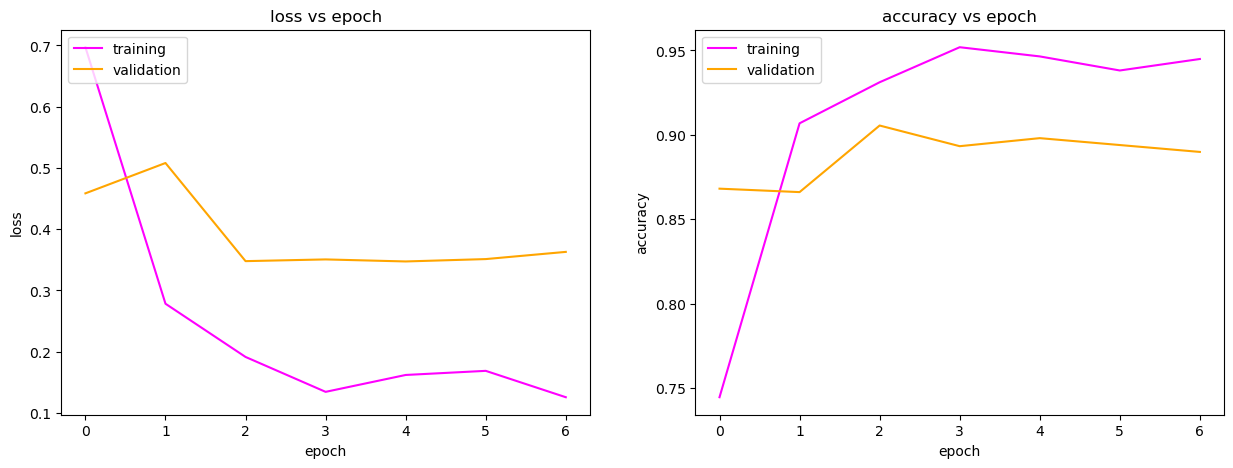


Model -->> LSTM_dual_model <<-- stopped after 5 epochs ::



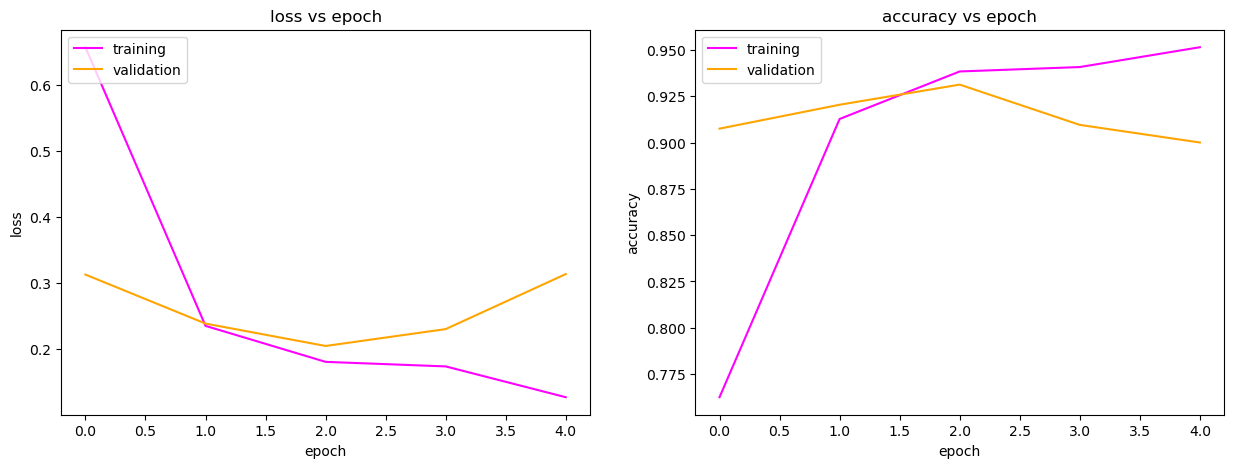


Model -->> CNN_LSTM_model <<-- stopped after 5 epochs ::



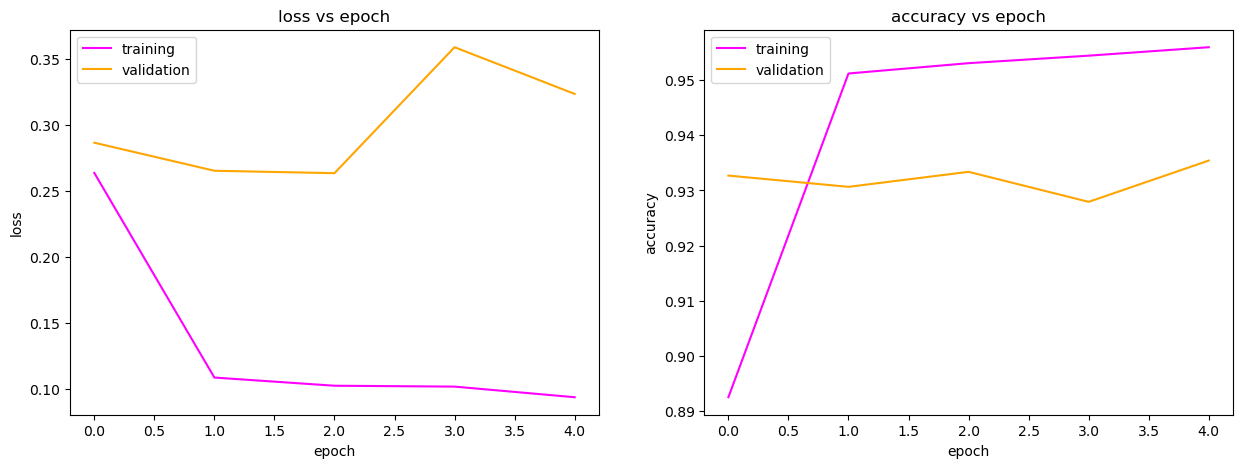


Model -->> bidir_LSTM_model <<-- stopped after 5 epochs ::



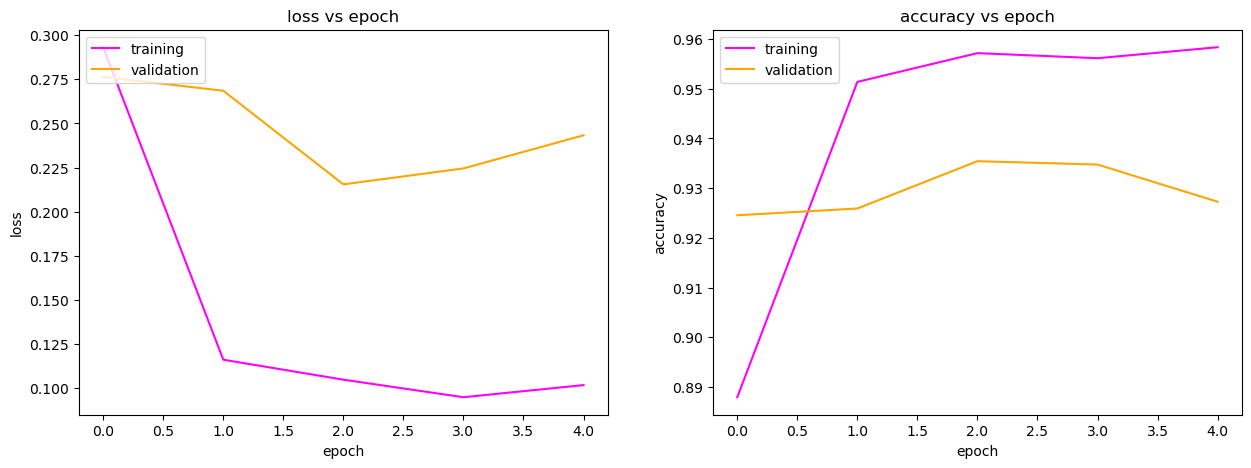

In [13]:
# Demonstrate validation loss & validation accuracy for each model
models = [model1, model2, model3, model4]
for model in models:
    epochs = int(len(model.history.history['loss']))
    print(f'\nModel -->> {model._name} <<-- ' \
          f'stopped after {epochs} epochs ::\n')
    plotHistory(model.history)

<center><h2><u>Model Prediction</u></h2></center>

In [14]:
# Run prediction of each model against testing data
models_tuned = [model1_tuned, model2_tuned, model3_tuned, model4_tuned]
best_loss, best_score = int(100), int(0)
for model, model_tuned in zip(models, models_tuned):
    score = GetAccuracy(model, x_test, y_test)
    loss = model_tuned['loss']
    print('\n\t', str(model._name), '.....', sep='')
    print('Model Loss ::', loss)
    print('Model Accuracy ::', score)
    if ((score > best_score) and (loss < best_loss)):
        best_model_name = str(model._name)
        best_loss = loss
        best_score = score
        model.save('generated_files/Final_Hinrichs_best-model.h5')
print('\nThe best-performing model on the Test Data is\n\t -->> ', best_model_name, \
      ' <<-- \nwith an accuracy score of', best_score, \
      '\nand minimal loss of', best_loss, '\n\n')

93/93 [==============================] - 2s 19ms/step

	LSTM_single_model.....
Model Loss :: 0.3473493754863739
Model Accuracy :: 0.9100780454699695
93/93 [==============================] - 2s 22ms/step

	LSTM_dual_model.....
Model Loss :: 0.20510324835777283
Model Accuracy :: 0.9110960298608755
93/93 [==============================] - 2s 21ms/step

	CNN_LSTM_model.....
Model Loss :: 0.26337477564811707
Model Accuracy :: 0.9202578893790295
93/93 [==============================] - 2s 17ms/step

	bidir_LSTM_model.....
Model Loss :: 0.21545638144016266
Model Accuracy :: 0.9267051238547676

The best-performing model on the Test Data is
	 -->>  LSTM_dual_model  <<-- 
with an accuracy score of 0.9110960298608755 
and minimal loss of 0.20510324835777283 




--- 

<center><h1><u>Analysis</u></h1></center>

--- 

|    | single-layer LSTM | dual-layer LSTM | combination CNN-LSTM | bi-directional LSTM |
| --- | --- | --- | --- | --- |
| Loss | .3473 | .2051 | .2634 | .2155 |
| Accuracy | .9101 | .9111 | .9203 | .9267 |

<h4><center>Best Model :: dual-layer or bi-directional LSTM</center></h4><br><br><br><br><br>